# Leaf classifier

https://www.kaggle.com/c/leaf-classification/data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pickle as pk
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_sub_df = pd.read_csv('sample_submission.csv')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


In [10]:
# Encode species
label_encoder = LabelEncoder()
label_encoder.fit(train_df['species'])
train_df['label'] = label_encoder.transform(train_df['species'])

In [11]:
train_df.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,label
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391,3
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461,49
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930,65
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852,94
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250,84


In [12]:
# Check number of elements per specie
pd.DataFrame(train_df['species'].value_counts())

,species
Quercus_Nigra,10
Quercus_Canariensis,10
Quercus_Chrysolepis,10
Acer_Circinatum,10
Quercus_Cerris,10
...,...
Quercus_Dolicholepis,10
Quercus_Pyrenaica,10
Acer_Saccharinum,10
Alnus_Cordata,10


Text(0.5, 0, 'features')

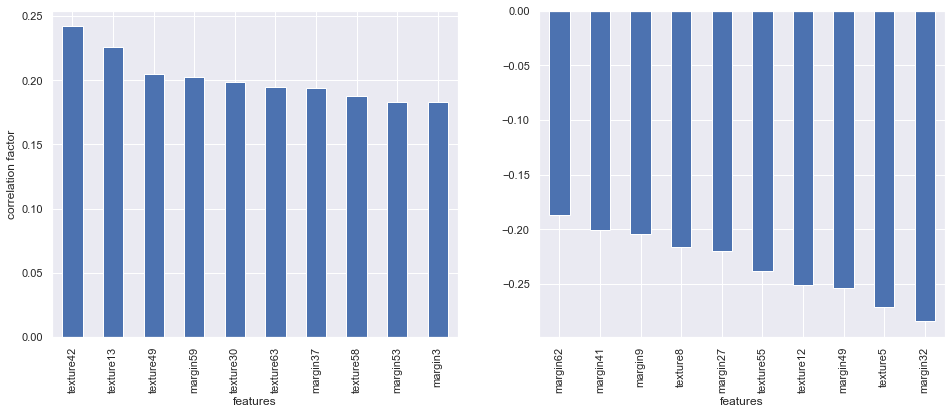

In [13]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(16, 6))

# max positive correlation
plt.subplot(1, 2, 1)
train_df.corr()['label'].sort_values(ascending=False).iloc[1:11].plot(kind='bar')
plt.xlabel('features')
plt.ylabel('correlation factor')

# max negative correlation
plt.subplot(1, 2, 2)
train_df.corr()['label'].sort_values(ascending=False).tail(10).plot(kind='bar')
plt.xlabel('features')

In [15]:
X = np.array(train_df[[col for col in list(train_df) if col not in ['id','species','label']]])
y = np.array(train_df['label'])

## Unsupervised learning

In [62]:
# stochastic neighbourhood embedding
tsne = TSNE(
    n_components=2,
    init='random',
    random_state=42,
    perplexity=30,
    early_exaggeration=20,
    n_iter=800
)

Tx = tsne.fit_transform(X)

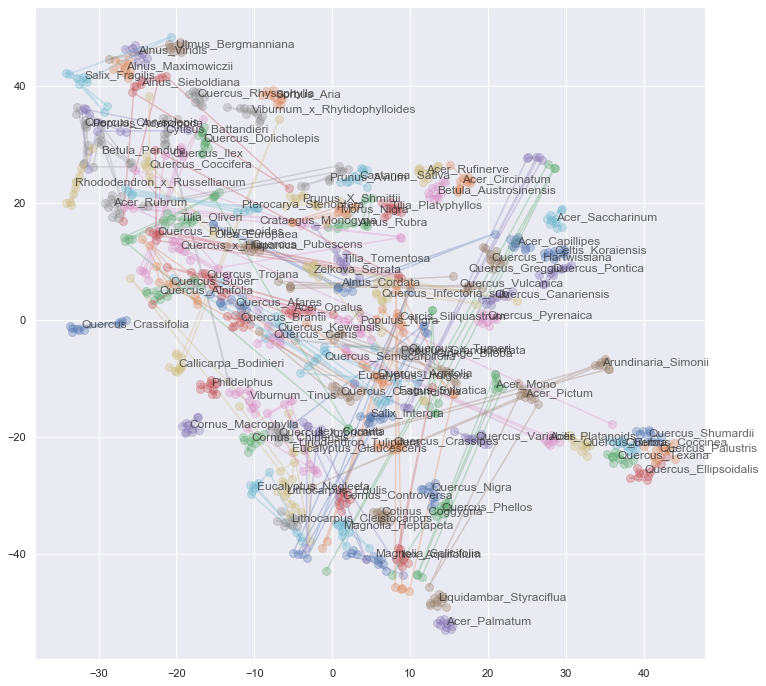

In [63]:
fig, ax = plt.subplots(figsize=(12, 12))
for target in np.unique(y):
    selection = y == target
    X1, X2 = Tx[selection,0], Tx[selection,1]
    c1, c2 = np.median(X1), np.median(X2)
    plt.plot(X1, X2, '-o', ms=8, alpha = 0.3)
    plt.text(c1, c2, label_encoder.inverse_transform([target])[0], fontsize=12, alpha=0.7)

In [16]:
# Generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Size of sets
print("X Train set:",X_train.shape)
print("y Train set:",y_train.shape)
print("X Test set:",X_test.shape)
print("y Test set:",y_test.shape)

X Train set: (693, 192)
y Train set: (693,)
X Test set: (297, 192)
y Test set: (297,)


In [17]:
# cross-validator : Stratified Shuffle Split 
sss = StratifiedShuffleSplit(n_splits = 20, test_size = 0.3, random_state = 42) # To avoid over-fitting

# Functions to be used in the pipeline
skb = SelectKBest(f_classif)

### Define classifier ###
clf = LinearDiscriminantAnalysis()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ('SKB',skb),
    ('LDA',clf)
])   

# parameters to tune 
param_grid = {
    'SKB__k':[20,30,50,100,150,'all'],
    'LDA__solver':['svd','lsqr','eigen'],
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

# training classifier
print (" > training classifier on training set:")
t0 = time()
grid.fit(X_train, y_train)
print ("training time: ", round(time()-t0, 3), "s")

# best classifier using the cross-validator and the Stratified Shuffle Split 
clf = grid.best_estimator_

# predicition with the classifier
print (" > testing classifier on testing set:")
t0 = time()
y_pred = clf.predict(X_test)
print ("testing time: ", round(time()-t0, 3), "s")

# print grid parameters
print ("\n > Best grid search:")
print (grid.best_params_)

# dump classifier in a pickle file
print ("\n > Classifier dumped")
with open("leaf_classifier.pkl", 'wb') as fid:
    pk.dump(clf, fid)
    
print(classification_report(y_test, y_pred))

 > training classifier on training set:
Fitting 20 folds for each of 18 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


training time:  17.516 s
 > testing classifier on testing set:
testing time:  0.0 s

 > Best grid search:
{'LDA__solver': 'svd', 'SKB__k': 'all'}

 > Classifier dumped
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   17.3s finished


In [18]:
# Load classifier
with open("leaf_classifier.pkl", 'rb') as file:
    clf_trained = pk.load(file)

In [19]:
X_user = np.array(test_df[[col for col in list(train_df) if col not in ['id','species','label']]])

In [21]:
# predictions on user data
user_pred = label_encoder.inverse_transform(clf_trained.predict(X_user))
print(user_pred[0:5])

['Quercus_Agrifolia' 'Quercus_Afares' 'Acer_Circinatum' 'Castanea_Sativa'
 'Alnus_Viridis']


In [23]:
sample_sub_df.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
1,7,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
2,9,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
3,12,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
4,13,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


In [28]:
### predictions on user data
user_pred_proba = clf_trained.predict_proba(X_user)
df_results = pd.DataFrame(user_pred_proba, columns=list(label_encoder.classes_))
df_results['prediction'] = user_pred
df_results.head()

,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,...,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata,prediction
0,6.817711e-122,4.092711e-202,6.398788e-179,4.180542e-62,0.000000e+00,3.075203e-125,8.840330e-158,3.694470e-142,5.206859e-133,6.579606e-280,...,1.786769e-108,5.377442e-198,1.473164e-132,4.257865e-139,1.119703e-114,1.963211e-178,5.196820e-137,1.101872e-128,9.405885e-167,Quercus_Agrifolia
1,2.052849e-151,3.270827e-226,2.803828e-129,4.703814e-56,0.000000e+00,4.068479e-104,2.263867e-61,1.049901e-110,1.604511e-118,3.399801e-281,...,9.128157e-98,1.355692e-216,3.800288e-134,2.287596e-164,2.996537e-91,4.816358e-164,2.902622e-76,9.162059e-184,9.131318e-108,Quercus_Afares
2,9.332118e-159,1.000000e+00,5.801387e-157,1.770817e-123,2.314339e-116,1.126346e-146,1.984683e-204,2.702366e-113,7.292188e-96,4.452989e-218,...,2.208287e-164,1.175814e-266,2.518533e-157,2.201460e-146,1.346687e-87,6.747808e-101,6.145128e-182,6.843079e-265,7.665385e-118,Acer_Circinatum
3,2.534425e-113,2.988382e-70,6.082607e-230,1.077998e-98,0.000000e+00,1.122335e-177,2.270161e-168,3.770565e-127,1.890205e-94,3.425429e-142,...,1.050583e-170,2.282853e-197,1.105794e-146,3.078653e-122,5.317658e-82,5.795055e-59,1.334862e-144,8.129168e-230,6.299887e-41,Castanea_Sativa
4,5.016675e-139,2.660487e-169,3.154100e-227,4.793705e-159,0.000000e+00,1.660760e-192,5.454383e-184,6.811641e-132,1.454553e-77,3.867675e-216,...,5.769841e-184,1.525252e-209,1.335303e-168,2.410652e-127,3.922999e-103,2.014168e-84,2.256796e-191,4.017628e-264,7.723990e-158,Alnus_Viridis


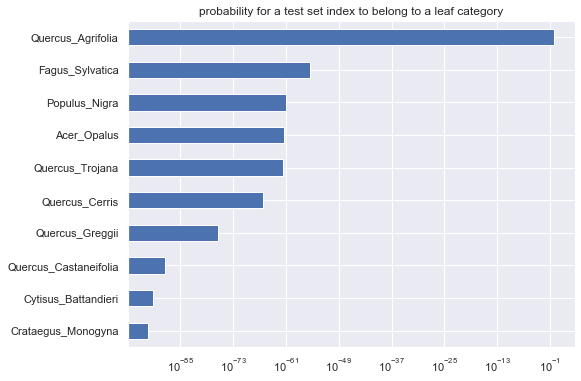

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
# test results
row = 0
test_index = df_results.drop('prediction',axis=1,inplace=False).iloc[row]
test_index.sort_values(ascending=False).head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('probability for a test set index to belong to a leaf category');

## Submission

In [45]:
df_submission = df_results.drop('prediction',axis=1)
df_submission.insert(0, 'id', test_df['id'])

print(df_submission.shape)
print(sample_sub_df.shape)

(594, 100)
(594, 100)


In [46]:
df_submission.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,6.817711e-122,4.092711e-202,6.398788e-179,4.180542e-62,0.000000e+00,3.075203e-125,8.840330e-158,3.694470e-142,5.206859e-133,...,3.840062e-228,1.786769e-108,5.377442e-198,1.473164e-132,4.257865e-139,1.119703e-114,1.963211e-178,5.196820e-137,1.101872e-128,9.405885e-167
1,7,2.052849e-151,3.270827e-226,2.803828e-129,4.703814e-56,0.000000e+00,4.068479e-104,2.263867e-61,1.049901e-110,1.604511e-118,...,2.971914e-205,9.128157e-98,1.355692e-216,3.800288e-134,2.287596e-164,2.996537e-91,4.816358e-164,2.902622e-76,9.162059e-184,9.131318e-108
2,9,9.332118e-159,1.000000e+00,5.801387e-157,1.770817e-123,2.314339e-116,1.126346e-146,1.984683e-204,2.702366e-113,7.292188e-96,...,9.459318e-183,2.208287e-164,1.175814e-266,2.518533e-157,2.201460e-146,1.346687e-87,6.747808e-101,6.145128e-182,6.843079e-265,7.665385e-118
3,12,2.534425e-113,2.988382e-70,6.082607e-230,1.077998e-98,0.000000e+00,1.122335e-177,2.270161e-168,3.770565e-127,1.890205e-94,...,1.460878e-219,1.050583e-170,2.282853e-197,1.105794e-146,3.078653e-122,5.317658e-82,5.795055e-59,1.334862e-144,8.129168e-230,6.299887e-41
4,13,5.016675e-139,2.660487e-169,3.154100e-227,4.793705e-159,0.000000e+00,1.660760e-192,5.454383e-184,6.811641e-132,1.454553e-77,...,6.093657e-182,5.769841e-184,1.525252e-209,1.335303e-168,2.410652e-127,3.922999e-103,2.014168e-84,2.256796e-191,4.017628e-264,7.723990e-158


In [49]:
df_submission.to_csv('submission.csv', index=False)